# Regression: Predicting fuel efficiency

Other models have been focused on classification, which is selecting from a finite number of possibilities. Regression aims to predict continuous values.


Imports. And appearently that makes numpy outputs easier to read.


In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)


Importing Tensorflow


In [92]:
import tensorflow as tf

print(tf.__version__)


2.8.0


Using pandas to get the csv


In [93]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
colunm_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]
raw_ds = pd.read_csv(
    url, names=colunm_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True
)



Printing the last 5 values


In [94]:
raw_ds.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


isna() returns True when something is N/A. The next line prints those values


In [95]:
raw_ds.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Getting rid of N/A Values


In [96]:
raw_ds = raw_ds.dropna()


Mapping the Origin which is a number between 1-3 to be True/False for an origin instead.


In [97]:
raw_ds["Origin"] = raw_ds["Origin"].map({1: "USA", 2: "Europe", 3: "Japan"})
raw_ds = pd.get_dummies(raw_ds, columns=["Origin"], prefix="", prefix_sep="")
raw_ds.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Splitting 80% of the dataset into training data


In [98]:
train_ds = raw_ds.sample(frac=0.8, random_state=0)
test_ds = raw_ds.drop(train_ds.index)


Printing out the data to vizualize relationships


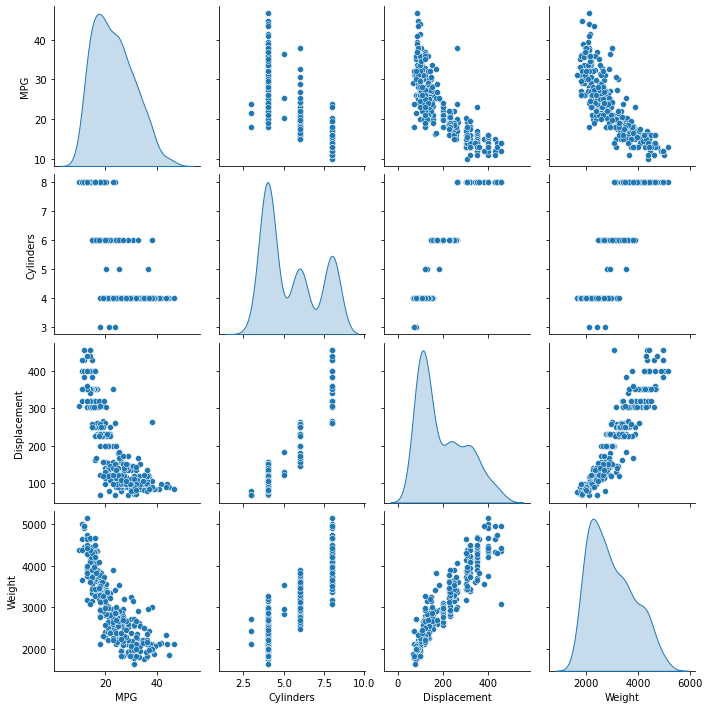

In [99]:
sns.pairplot(train_ds[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


`train_ds` is a pandas DataFrame, these functions put it into a table


In [100]:
train_ds.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


adding only MPG to a label array, and having another array where it is removed. x and y arrays essentially


In [101]:
train_features = train_ds.copy()
test_features = test_ds.copy()

train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")


pandas table for only the means and standard deviations


In [102]:
train_ds.describe().transpose()[["mean", "std"]]


,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


Normalization is not strictly required, but simplifies things


In [103]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
normalizer.mean.numpy()


array([[   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
           0.178,    0.197,    0.624]], dtype=float32)

Not sure why there is a `nan`, but oh well


In [104]:
first = np.array(train_features[:1])
with np.printoptions(precision=2, suppress=True):
    print("First example:", first)
    print()
    print("Normalized:", normalizer(first).numpy())


First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Simple linear regression


This will use `Horsepower` to predict `MPG`. There are only two steps to this process. First the normalization, then applying linear transformation.


In [105]:
horsepower = np.array(train_features["Horsepower"])
hp_norm = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
hp_norm.adapt(horsepower)


After normalizing the horsepower data, we can build the sequential model


In [106]:
hp_model = tf.keras.Sequential([hp_norm, tf.keras.layers.Dense(units=1)])
hp_model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_19 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Now, let's check that we have the derised output. For every input we should have a MPG estimate. Here there are 10 horsepower inputs, so there should be 10 mpg outputs


In [107]:
hp_model.predict(horsepower[:10])


array([[ 0.9  ],
       [ 0.508],
       [-1.661],
       [ 1.261],
       [ 1.141],
       [ 0.448],
       [ 1.352],
       [ 1.141],
       [ 0.297],
       [ 0.508]], dtype=float32)

Now to add an optimizer and loss funciton.


In [108]:
hp_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mean_absolute_error"
)


We can now train the model


In [109]:
%%time
history = hp_model.fit(
    train_features["Horsepower"],
    train_labels,
    epochs=100,
    verbose=0, # to suppress logging
    validation_split = 0.2
)

CPU times: user 4.19 s, sys: 369 ms, total: 4.56 s
Wall time: 10.6 s


We can now visualize the data


In [110]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,3.802644,4.189684,95
96,3.804426,4.180883,96
97,3.803817,4.182774,97
98,3.805125,4.187070,98
99,3.807807,4.214183,99


In [111]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 10])
    plt.xlabel("Epoch")
    plt.ylabel("Error (MPG)")
    plt.legend()
    plt.grid(True)


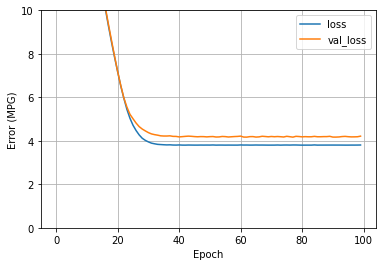

In [112]:
plot_loss(history)


In [113]:
test_results = {}
test_results["horsepower_model"] = hp_model.evaluate(
    test_features["Horsepower"], test_labels, verbose=0
)



In [114]:
x = tf.linspace(0.0, 250, 251)
y = hp_model.predict(x)


Let's make a graph for it


In [115]:
def plot_horsepower(x, y):
    plt.scatter(train_features["Horsepower"], train_labels, label="Data")
    plt.plot(x, y, color="k", label="Predictions")
    plt.xlabel("Horsepower")
    plt.ylabel("MPG")
    plt.legend()


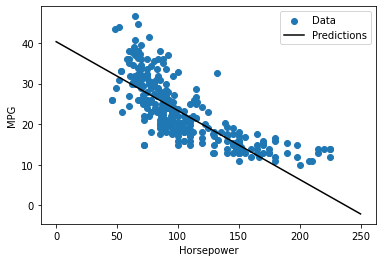

In [116]:
plot_horsepower(x, y)


A similar setup can be used with mutiple variables. Instead of having _y = mx + b_, where m and b are real numbers, _m_ will be a matrix, and ~b~ will be a 1-dimensional matrix, or a vector.


In [117]:
linear_model = tf.keras.Sequential(
    [
        normalizer,
        tf.keras.layers.Dense(1),  # units is the first input. same as saying units=1
    ]
)



In [118]:
linear_model.predict(train_features[:10])


array([[ 0.054],
       [-0.508],
       [-0.161],
       [-0.381],
       [-1.276],
       [-0.385],
       [-1.346],
       [ 2.259],
       [-0.124],
       [-1.169]], dtype=float32)

Checking the weights of the model


In [119]:
linear_model.layers[1].kernel


<tf.Variable 'dense_20/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.065],
       [-0.049],
       [-0.721],
       [ 0.502],
       [-0.352],
       [-0.289],
       [ 0.707],
       [-0.61 ],
       [-0.464]], dtype=float32)>

Time to compile this model and then fit it will 100 epochs again


In [120]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mean_absolute_error"
)


In [121]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.89 s, sys: 347 ms, total: 4.24 s
Wall time: 4.16 s


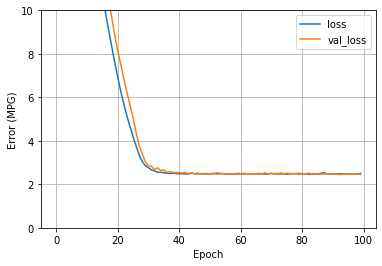

In [122]:
plot_loss(history)


In [123]:
test_results["linear_model"] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

https://www.tensorflow.org/tutorials/keras/regression#regression_with_a_deep_neural_network_dnn


They call this regression with a deep neural network, which in reality just means there are a couple hidden layers. The only thing that will be different between a single-variable DNN and a multi-variable one is the normalizer. 

In [124]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [125]:
dnn_horsepower_model = build_and_compile_model(hp_norm)
dnn_horsepower_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_21 (Dense)            (None, 64)                128       
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [126]:
%%time
history = dnn_horsepower_model.fit(train_features["Horsepower"], train_labels, validation_split=0.2, verbose=0, epochs=100)

CPU times: user 4.29 s, sys: 416 ms, total: 4.7 s
Wall time: 4.35 s


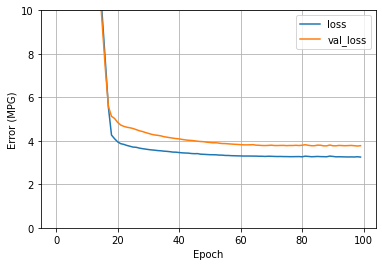

In [127]:
plot_loss(history)

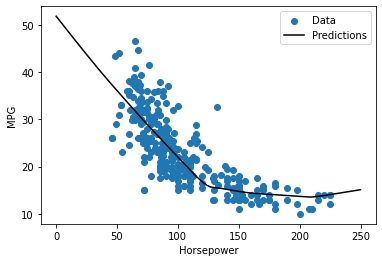

In [128]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)

In [129]:
test_results["dnn_horsepower_model"] = dnn_horsepower_model.evaluate(
    test_features["Horsepower"], test_labels, verbose=0
)


Same thing, now with multiple inputs

In [130]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_24 (Dense)            (None, 64)                640       
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [131]:
%%time
history = dnn_model.fit(
    train_features, train_labels, validation_split=0.2, verbose=0, epochs=100
)

CPU times: user 4.45 s, sys: 434 ms, total: 4.89 s
Wall time: 4.53 s


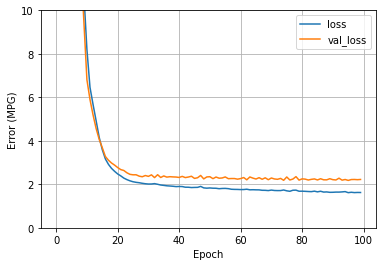

In [132]:
plot_loss(history)

In [133]:
test_results["dnn_model"] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [135]:
pd.DataFrame(test_results, index=["Mean absolute error (MPG)"]).T

,Mean absolute error (MPG)
horsepower_model,3.650374
linear_model,2.435382
dnn_horsepower_model,2.933307
dnn_model,1.703807


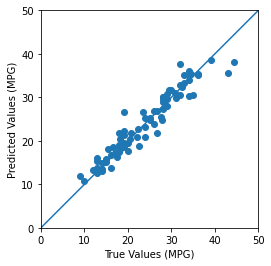

In [141]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect="equal")
plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values (MPG)")
plt.ylabel("Predicted Values (MPG)")
lims = (0, 50)
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

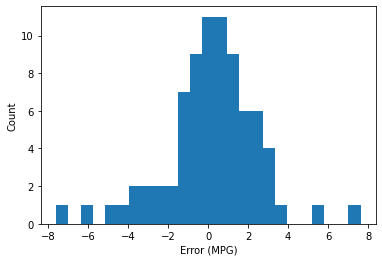

In [142]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Error (MPG)")
_ = plt.ylabel("Count")

In [143]:
dnn_model.save("dnn_model")

2022-05-12 20:10:02.588432: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dnn_model/assets


# Hypothetically this could be started again here